# Predictive  maintainance

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load dataset
file_path = '/Users/zxgan/FYP_Kubernetes/Dataset/node_node_0_dataset.csv'
data = pd.read_csv(file_path)

## LSTM

In [12]:
# Import necessary libraries
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


# Define features and targets
features = data.drop(columns=['timestamp', 'node_name', 'pod_status_Running', 'pod_status_Pending', 
                               'pod_status_Succeeded', 'pod_status_Failed', 'pod_status_Unknown'])
targets = data[['pod_status_Running', 'pod_status_Pending', 'pod_status_Succeeded', 
                'pod_status_Failed', 'pod_status_Unknown']].idxmax(axis=1).astype('category').cat.codes

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42, stratify=targets)

In [13]:
# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape inputs for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Define the LSTM model
def build_lstm_model(input_shape, num_classes, units, dropout_rate, l2_reg=None):
    reg = l2(l2_reg) if l2_reg else None

    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape, kernel_regularizer=reg),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=False, kernel_regularizer=reg),
        Dropout(dropout_rate),
        Dense(units // 4, activation='relu', kernel_regularizer=reg),
        Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
    ])
    return model

# Input shape and number of classes
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
num_classes = len(np.unique(y_train))  # Ensure num_classes is correct

# Hyperparameter configurations
units_options = [64]
dropout_rates = [0.2]
learning_rates = [0.001]
batch_sizes = [32]
l2_regs = [0.01]
epochs_options = [30]

config_combinations = list(itertools.product(units_options, dropout_rates, learning_rates, batch_sizes, l2_regs, epochs_options))

# Train and evaluate models
def train_model(config):
    units, dropout_rate, learning_rate, batch_size, l2_reg, epochs = config
    
    # Build model
    model = build_lstm_model(input_shape, num_classes, units, dropout_rate, l2_reg)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    
    # Train model
    history = model.fit(
        X_train_lstm, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_lstm, y_test),
        callbacks=[early_stopping, lr_scheduler],
        verbose=2
    )
    return model, history

# Train and store models
models_histories = []
for config in config_combinations:
    print(f"Training with config: {config}")
    model, history = train_model(config)
    models_histories.append((model, history, config))

# Select the best model
best_model = None
best_config = None
best_val_accuracy = 0

for model, history, config in models_histories:
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_config = config

print(f"Best Model Configuration: {best_config}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Training with config: (64, 0.2, 0.001, 32, 0.01, 30)
Epoch 1/30
9/9 - 1s - loss: 2.8724 - accuracy: 0.1654 - val_loss: 2.7640 - val_accuracy: 0.2985 - lr: 0.0010 - 1s/epoch - 161ms/step
Epoch 2/30
9/9 - 0s - loss: 2.6966 - accuracy: 0.2180 - val_loss: 2.6012 - val_accuracy: 0.1940 - lr: 0.0010 - 24ms/epoch - 3ms/step
Epoch 3/30
9/9 - 0s - loss: 2.5412 - accuracy: 0.2444 - val_loss: 2.4581 - val_accuracy: 0.2239 - lr: 0.0010 - 24ms/epoch - 3ms/step
Epoch 4/30
9/9 - 0s - loss: 2.4059 - accuracy: 0.1767 - val_loss: 2.3338 - val_accuracy: 0.2537 - lr: 0.0010 - 25ms/epoch - 3ms/step
Epoch 5/30
9/9 - 0s - loss: 2.2887 - accuracy: 0.2143 - val_loss: 2.2267 - val_accuracy: 0.2090 - lr: 0.0010 - 24ms/epoch - 3ms/step
Epoch 6/30
9/9 - 0s - loss: 2.1879 - accuracy: 0.2143 - val_loss: 2.1349 - val_accuracy: 0.2090 - lr: 0.0010 - 24ms/epoch - 3ms/step
Epoch 7/30
9/9 - 0s - loss: 2.1020 - accuracy: 0.2143 - val_loss: 2.0564 - val_accuracy: 0.2090 - lr: 0.0010 - 24ms/epoch - 3ms/step
Epoch 8/30
9/9 -

In [14]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

# Example input and target for demonstration
example_input = X_test_lstm[0]
example_target = y_test[0]

print("\nExample Input Sequence:")
display(example_input)
print("\nExample Target:")
print(example_target)

# Make prediction using the best model
prediction = best_model.predict(example_input.reshape(1, 1, -1))

# Convert probabilities to a percentage format
probabilities = prediction[0] * 100
pod_status_labels = ['pod_status_Running', 'pod_status_Pending', 'pod_status_Succeeded', 'pod_status_Failed', 'pod_status_Unknown']

# Create a DataFrame for the probabilities
probability_df = pd.DataFrame({
    "Pod Status": pod_status_labels,
    "Probability (%)": probabilities
})

# Display the probabilities interactively
print("\nInteractive Probability Table:")
display(probability_df)

# Interactive Bar Plot
fig = px.bar(
    probability_df,
    x="Pod Status",
    y="Probability (%)",
    title="Prediction Probabilities for Pod Statuses",
    labels={"Probability (%)": "Probability (%)"},
    text="Probability (%)",
    hover_data={"Probability (%)": True},
    color="Pod Status"
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    xaxis_title="Pod Status",
    yaxis_title="Probability (%)",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template="plotly_white"
)

# Show the interactive bar chart
fig.show()

# Interactive Pie Chart
pie_fig = px.pie(
    probability_df,
    values="Probability (%)",
    names="Pod Status",
    title="Prediction Probabilities for Pod Statuses (Pie Chart)",
    hover_data={"Probability (%)": True},
    labels={"Probability (%)": "Probability (%)"},
    template="plotly_white"
)
pie_fig.update_traces(textposition='inside', textinfo='percent+label')

# Show the interactive pie chart
pie_fig.show()


Example Input Sequence:


array([[0.69096781, 0.36921065, 0.58456517, 0.41413956, 0.6912696 ,
        0.86021789, 0.06220106, 0.92622381, 0.250005  , 0.88438831,
        0.61659347, 0.29221251, 0.00366853, 0.59056364]])


Example Target:
3
1/1 [==============================] - 0s 294ms/step

Interactive Probability Table:


,Pod Status,Probability (%)
0,pod_status_Running,21.288378
1,pod_status_Pending,20.245544
2,pod_status_Succeeded,18.222080
3,pod_status_Failed,20.987026
4,pod_status_Unknown,19.256969


## ARIMA

Processing status: Running


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWa

Best ARIMA parameters for Running: (2, 0, 1) with AIC: 148.35745016836162


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



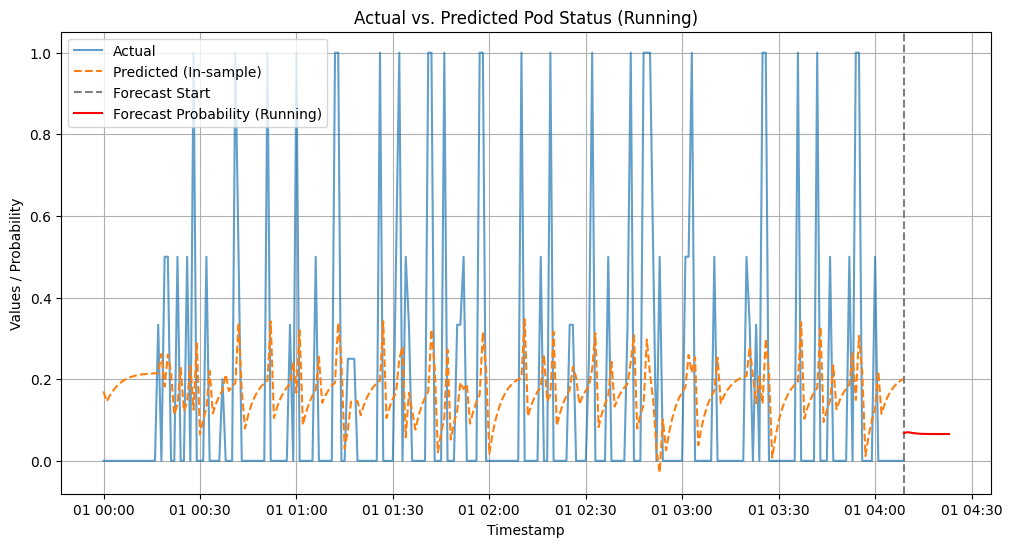

Processing status: Pending


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregress

Best ARIMA parameters for Pending: (0, 0, 2) with AIC: 145.51780938510615


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



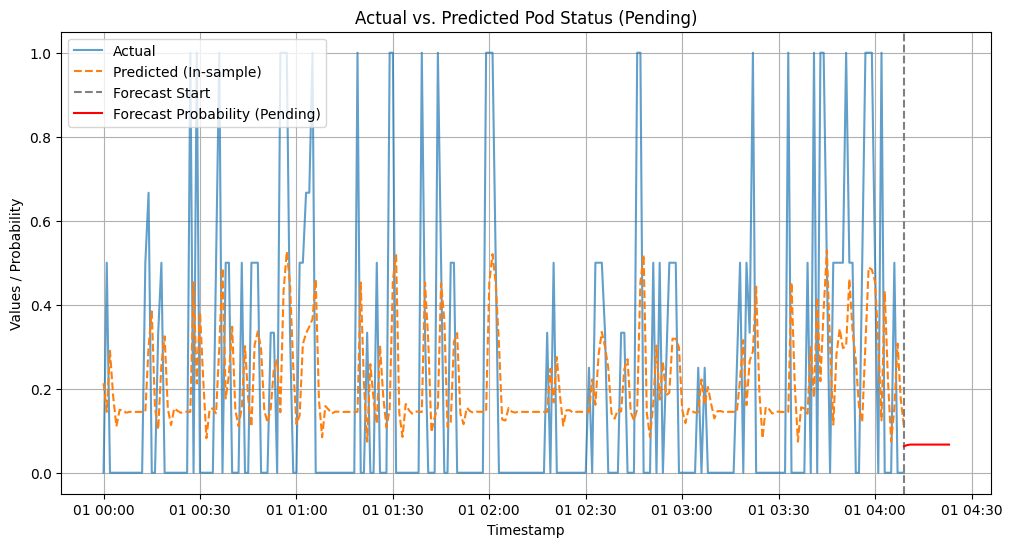

Processing status: Succeeded


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserW

Best ARIMA parameters for Succeeded: (2, 0, 1) with AIC: 159.91520191703228


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



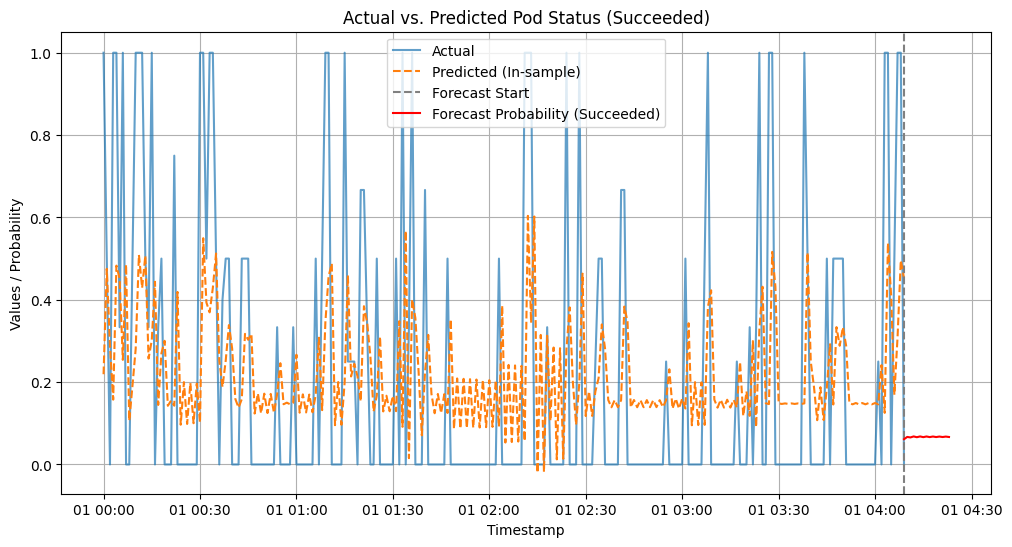

Processing status: Failed


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Best ARIMA parameters for Failed: (1, 0, 1) with AIC: 169.3837820593863


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



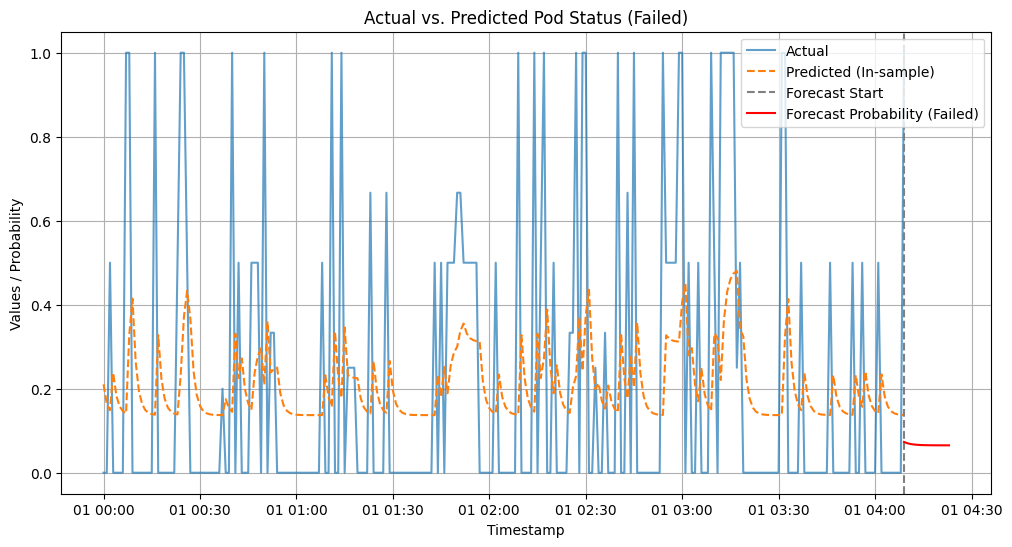

Processing status: Unknown


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum 

Best ARIMA parameters for Unknown: (1, 0, 0) with AIC: 151.59405306161523


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



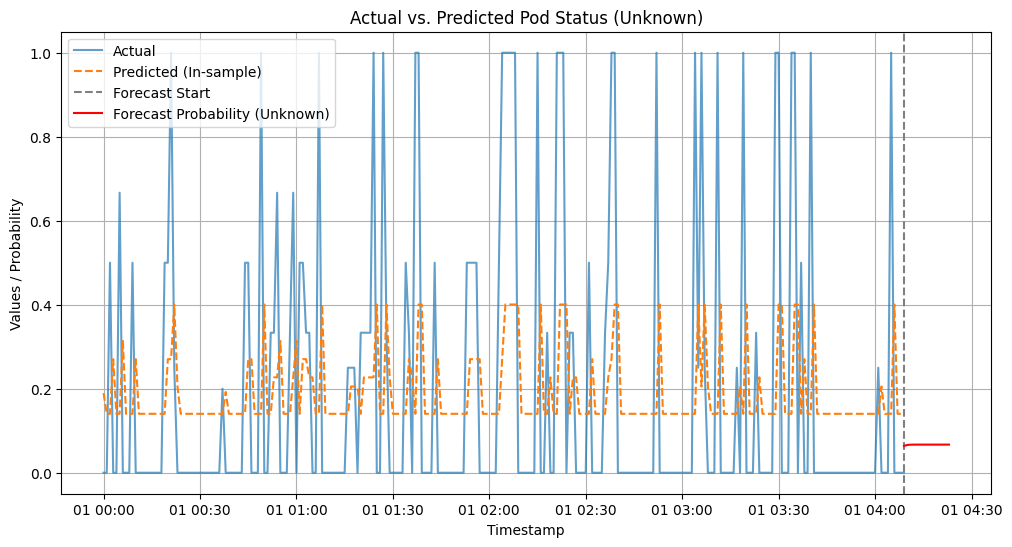

Probability Distribution for Pod Status Forecast:


,Running,Pending,Succeeded,Failed,Unknown
2023-01-01 04:09:00,0.067989,0.062984,0.061285,0.073260,0.063734
2023-01-01 04:10:00,0.070162,0.065835,0.066865,0.070286,0.066104
2023-01-01 04:11:00,0.069183,0.067014,0.065635,0.068433,0.066735
2023-01-01 04:12:00,0.067875,0.067014,0.068067,0.067263,0.066901
2023-01-01 04:13:00,0.066916,0.067014,0.066179,0.066518,0.066944
2023-01-01 04:14:00,0.066328,0.067014,0.068058,0.066043,0.066955
2023-01-01 04:15:00,0.065999,0.067014,0.066340,0.065738,0.066958
2023-01-01 04:16:00,0.065824,0.067014,0.067952,0.065541,0.066959
2023-01-01 04:17:00,0.065735,0.067014,0.066451,0.065415,0.066959
2023-01-01 04:18:00,0.065692,0.067014,0.067851,0.065334,0.066959


In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from IPython.display import display

dataset = data

# Preprocessing: Convert the 'timestamp' column to datetime format and set as index
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset = dataset.set_index('timestamp')

# Define the pod statuses to forecast
statuses = ["Running", "Pending", "Succeeded", "Failed", "Unknown"]
forecast_steps = 15  # Number of steps to forecast
probability_results = {}

for status in statuses:
    print(f"Processing status: {status}")
    # Resample and preprocess the pod status data for ARIMA modeling
    pod_status_series = dataset[f'pod_status_{status}'].resample('1T').mean().fillna(method='ffill').fillna(method='bfill')

    # Define the parameter grid for p, d, q values
    p = d = q = range(0, 3)  # Reduce range for faster processing; adjust as needed
    pdq = list(itertools.product(p, d, q))

    # Grid search for the best ARIMA parameters based on AIC
    best_aic = np.inf
    best_pdq = None
    best_model = None

    for param in pdq:
        try:
            model = sm.tsa.ARIMA(pod_status_series, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_model = results
        except:
            continue

    # Display the best parameters and their AIC value
    print(f"Best ARIMA parameters for {status}: {best_pdq} with AIC: {best_aic}")

    # Generate predictions for the training period
    train_predictions = best_model.fittedvalues

    # Forecast the next 'forecast_steps' time steps
    pod_status_forecast = best_model.forecast(steps=forecast_steps)

    # Apply softmax to normalize probabilities
    probabilities = softmax(pod_status_forecast.values.reshape(-1, 1), axis=0).flatten()

    # Store probabilities for this status
    probability_results[status] = probabilities

    # Visualize the results with Matplotlib
    plt.figure(figsize=(12, 6))
    plt.plot(pod_status_series.index, pod_status_series, label="Actual", alpha=0.7)
    plt.plot(best_model.fittedvalues.index, best_model.fittedvalues, label="Predicted (In-sample)", linestyle="--")
    plt.axvline(pod_status_series.index[-1], color='gray', linestyle='--', label="Forecast Start")
    plt.plot(
        pd.date_range(start=pod_status_series.index[-1], periods=forecast_steps, freq='1T'),
        probabilities, label=f"Forecast Probability ({status})", color='red'
    )
    plt.title(f"Actual vs. Predicted Pod Status ({status})")
    plt.xlabel("Timestamp")
    plt.ylabel("Values / Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a DataFrame with probabilities for all statuses
probability_df = pd.DataFrame(
    probability_results,
    index=pd.date_range(start=dataset.index[-1], periods=forecast_steps, freq='1T')
)

# Interactive Visualization using Plotly
fig = px.bar(
    probability_df.reset_index(),
    x='index',
    y=statuses,
    labels={'index': 'Timestamp'},
    title="Forecasted Probabilities for Pod Statuses",
    barmode='group',
)
fig.update_layout(
    xaxis_title="Timestamp",
    yaxis_title="Probability",
    template="plotly_white",
)
fig.show()

# Print the combined probability distribution for all statuses
print("Probability Distribution for Pod Status Forecast:")
display(probability_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/9mdvtwy5.json


Processing status: Running


DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/i3oong31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97982', 'data', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/9mdvtwy5.json', 'init=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/i3oong31.json', 'output', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/prophet_modeluiqki02u/prophet_model-20250107011802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


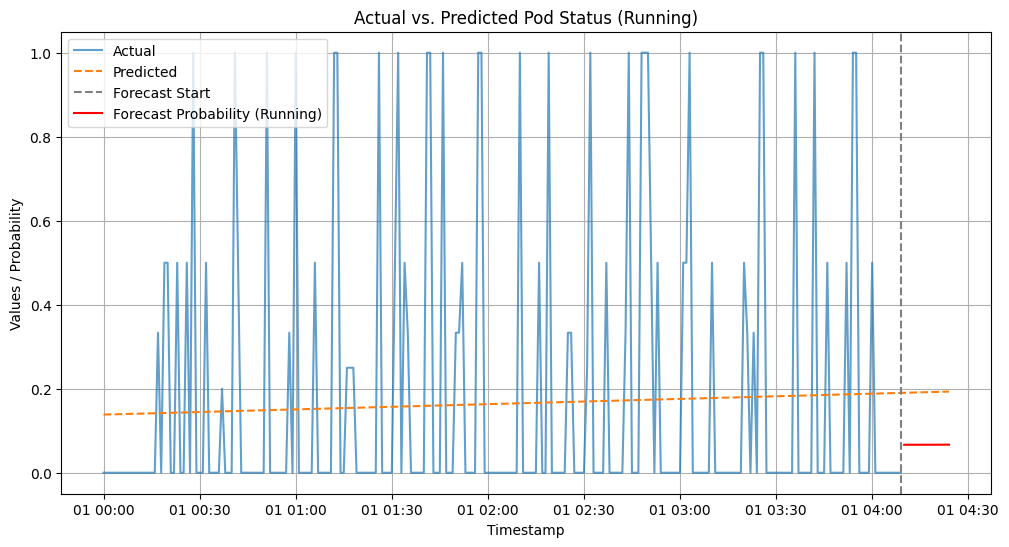

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/gao4n7ol.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/awr30n5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80609', 'data', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/gao4n7ol.json', 'init=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/awr30n5f.json', 'output', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000

Processing status: Pending


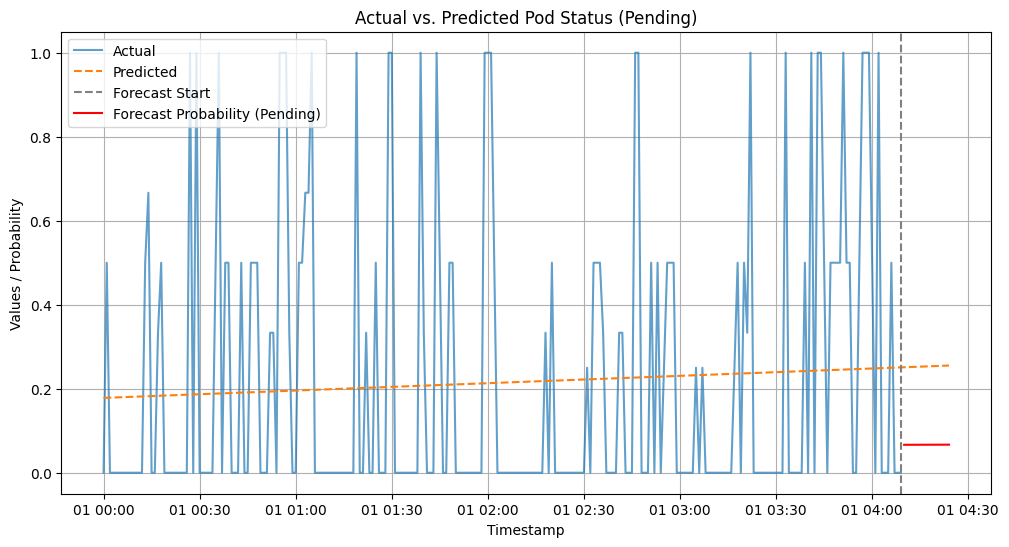

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/0j5diamb.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/bj38mit1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50655', 'data', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/0j5diamb.json', 'init=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/bj38mit1.json', 'output', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000

Processing status: Succeeded


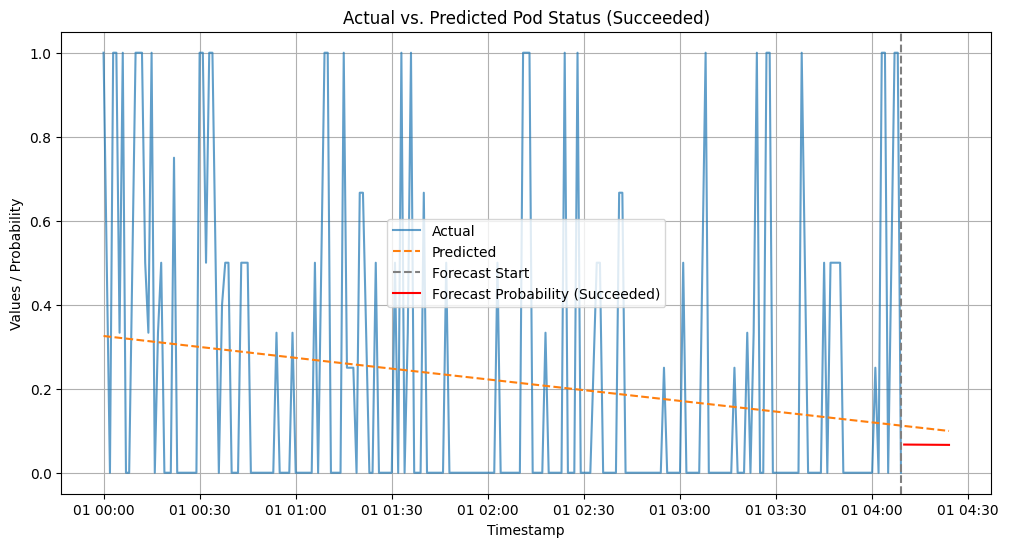

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/qap2z29x.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/lagu553b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45424', 'data', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/qap2z29x.json', 'init=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/lagu553b.json', 'output', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000

Processing status: Failed


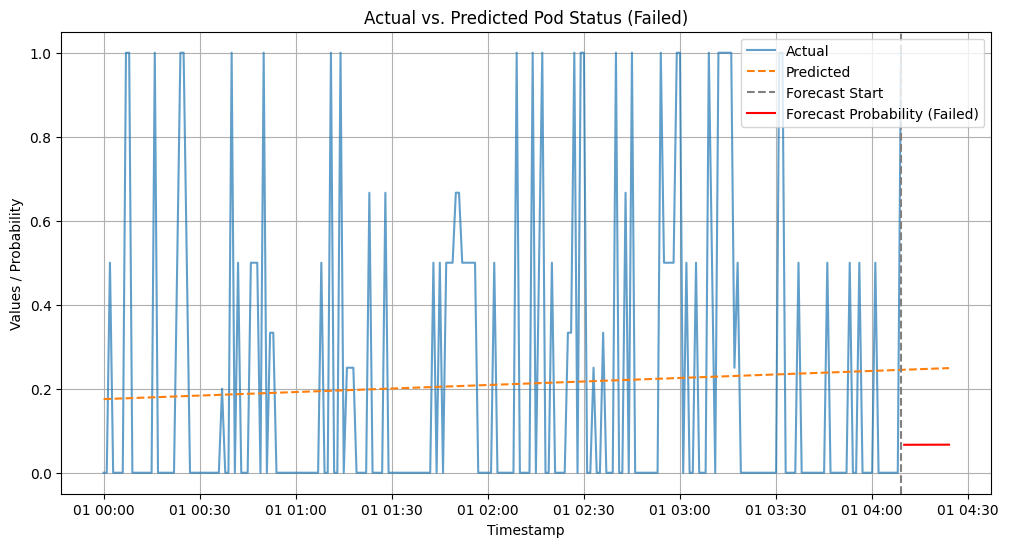

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/a35jb4cp.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/kjgtqsnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70445', 'data', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/a35jb4cp.json', 'init=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000gq/T/tmptcgoegaq/kjgtqsnj.json', 'output', 'file=/var/folders/g9/fy9_7gbd62198qfp82t1w1zw0000

Processing status: Unknown


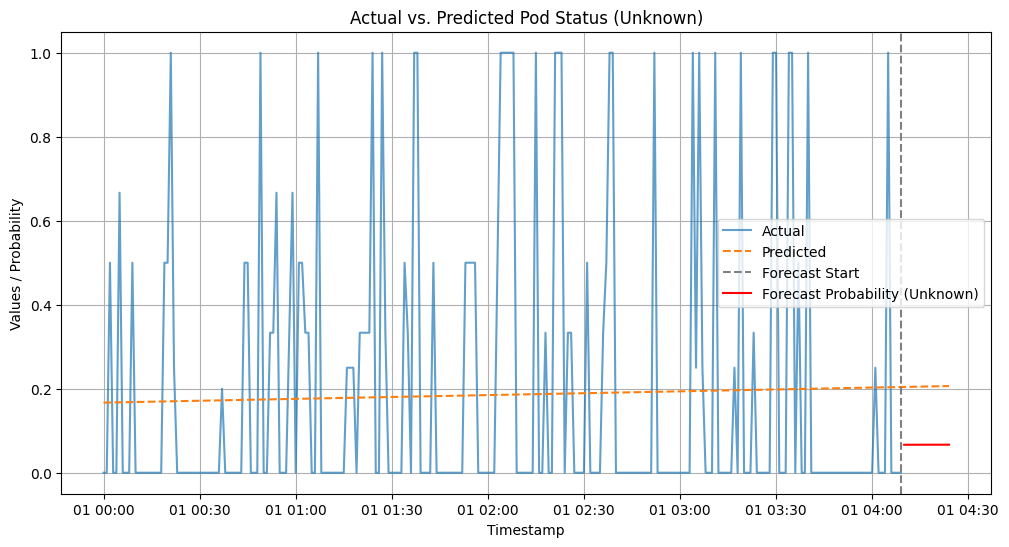

Probability Distribution for Pod Status Forecast:


,Running,Pending,Succeeded,Failed,Unknown
2023-01-01 04:09:00,0.066570,0.066531,0.067065,0.066536,0.066597
2023-01-01 04:10:00,0.066583,0.066550,0.067008,0.066555,0.066607
2023-01-01 04:11:00,0.066597,0.066569,0.066951,0.066574,0.066617
2023-01-01 04:12:00,0.066611,0.066589,0.066894,0.066592,0.066627
2023-01-01 04:13:00,0.066625,0.066608,0.066837,0.066611,0.066637
2023-01-01 04:14:00,0.066639,0.066628,0.066780,0.066629,0.066647
2023-01-01 04:15:00,0.066653,0.066647,0.066723,0.066648,0.066657
2023-01-01 04:16:00,0.066667,0.066667,0.066666,0.066667,0.066667
2023-01-01 04:17:00,0.066681,0.066686,0.066609,0.066685,0.066677
2023-01-01 04:18:00,0.066694,0.066706,0.066553,0.066704,0.066687


In [16]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.special import softmax

# Define pod statuses and forecast parameters
statuses = ["Running", "Pending", "Succeeded", "Failed", "Unknown"]
forecast_steps = 15  # Number of time steps to forecast
probability_results = {}

for status in statuses:
    print(f"Processing status: {status}")
    
    try:
        # Prepare the data for Prophet
        pod_status_series = dataset[f'pod_status_{status}'].resample('1T').mean().fillna(method='ffill').fillna(method='bfill')
        df_prophet = pod_status_series.reset_index()
        df_prophet.columns = ['ds', 'y']  # Prophet requires these column names
    except KeyError:
        print(f"Column 'pod_status_{status}' does not exist. Skipping.")
        continue

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(df_prophet)

    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=forecast_steps, freq='T')

    # Forecast the future values
    forecast = model.predict(future)

    # Extract forecast values for the desired period
    forecast_values = forecast[['ds', 'yhat']].tail(forecast_steps)

    # Apply softmax to normalize probabilities
    probabilities = softmax(forecast_values['yhat'].values.reshape(-1, 1), axis=0).flatten()

    # Store probabilities for this status
    probability_results[status] = probabilities

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", alpha=0.7)
    plt.plot(forecast['ds'], forecast['yhat'], label="Predicted", linestyle="--")
    plt.axvline(df_prophet['ds'].iloc[-1], color='gray', linestyle='--', label="Forecast Start")
    plt.plot(
        forecast_values['ds'],
        probabilities,
        label=f"Forecast Probability ({status})",
        color='red'
    )
    plt.title(f"Actual vs. Predicted Pod Status ({status})")
    plt.xlabel("Timestamp")
    plt.ylabel("Values / Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a DataFrame with probabilities for all statuses
probability_df = pd.DataFrame(
    probability_results,
    index=pd.date_range(start=dataset.index[-1], periods=forecast_steps, freq='1T')
)

# Display the probability distribution
print("Probability Distribution for Pod Status Forecast:")
display(probability_df)

In [17]:
print(best_config)

(64, 0.2, 0.001, 32, 0.01, 30)
